`copyright: abhirup.ghosh.184098@gmail.com`

# HAMS Data Science Challenge

The details of the data science challenge can be found [here](https://github.com/haensel-ams/recruitment_challenge/tree/master/DataScience_202209). 

The task was to:
1. build a Bayesian MMM with the latest [PyMC package](https://www.pymc.io/)
2. test it on the [given dataset](https://github.com/haensel-ams/recruitment_challenge/blob/master/DataScience_202209/MMM_test_data.csv)
3. interpret the insights from the model

To help with point 3., some questions were already provided:
* How do you model spend carry over?
* Explain your choice of prior inputs to the model?
* How are your model results based on prior sampling vs. posterior sampling?
* How good is your model performing? How you do measure it?
* What are your main insights in terms of channel performance/ effects?
* (Bonus) Can you derive ROI (return on investment) estimates per channel? What is the best channel in terms of ROI?

which we hope to answer in the analysis below.

# Resources

I put together a summary of the resources I referred to during this challenge: for a quick overview of the problem, state-of-the-art research and publicly-available implementations of Bayesian mixed media modelling.

* Quick Overview:
  * [Marketing Mix Modelling: Wikipedia](https://en.wikipedia.org/wiki/Marketing_mix_modeling)
  * [Media mix modeling (MMM): AppsFlyer](https://www.appsflyer.com/glossary/media-mix-modeling/)
* Research articles:  
  * [Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects, Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)
  * Caveats/Follow-ups:
    * [Challenges And Opportunities In Media Mix Modeling, D. Chan and M. Perry, Google Inc. (2017)](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45998.pdf)
    * [Bias Correction For Paid Search In Media Mix Modeling, Chen et al (2018)](https://arxiv.org/abs/1807.03292)
* Blog posts:
  * [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)
  * [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/)
  * [Bayesian Media Mix Modeling using PyMC3, for Fun and Profit: HelloFresh](https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6)
  * [BayesianMMM — State of the Art Media Mix Modelling](https://towardsdatascience.com/bayesianmmm-state-of-the-art-media-mix-modelling-9207c4445757)
* Publicly available codes:
  * [pymc-marketing](https://github.com/pymc-labs/pymc-marketing) from [pymc](https://www.pymc.io/welcome.html) with [example implementation](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) with [pymc-marketing](https://github.com/pymc-labs/pymc-marketing)
  * [BayesianMMM](https://github.com/leopoldavezac/BayesianMMM) related to the blog post [BayesianMMM — State of the Art Media Mix Modelling](https://towardsdatascience.com/bayesianmmm-state-of-the-art-media-mix-modelling-9207c4445757) [uses STAN]

# Environment

We can run the code in a conda environment that can be installed using the `.env.txt` provided with this notebook. All additional depenencies were installed using the `pip` inside the environment, using the command given below.

In [193]:
#! pip install pandas seaborn numpy matplotlib scikit-learn jupyter pymc pymc_marketing graphviz

Questions:
* revenue/spends units euros
* what value of L
* log revenue
* control variables?
* normalise the revenue/spend variables

# Analysis

<span style="color:red">DISCLAIMER:</span> A lot of the code used in this notebook is recycled from [here](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html).

## Dependencies

In [194]:
# dependencies 
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm

# set plotting style
sns.set_style("whitegrid")

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.utils import generate_fourier_modes

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data: MMM_test_data.csv

The dataset consists of:
* `start_of_week`: first day of the week `(time variable)`
* `revenue`: revenue generated in this week from sales `(target/dependent variable)`
* `spend_channel_1..7`: marketing cost spend in this week in channel 1..7 `(independent variables)`


In [195]:
# Assumes data file (MMM_test_data.csv) 
# lies in the same folder as the notebook

df = pd.read_csv('./MMM_test_data.csv', parse_dates=['start_of_week'], dayfirst=True) # assigning 'start_of_week' as a datetime-type column
#df.info() # to ensure there are no NULLs and all variables are the correct type
df.head().T

,0,1,2,3,4
start_of_week,2020-08-30 00:00:00,2020-09-06 00:00:00,2020-09-13 00:00:00,2020-09-20 00:00:00,2020-09-27 00:00:00
revenue,157906.75,186425.68,161607.39,180089.13,217793.98
spend_channel_1,2625.48,2634.01,2087.08,1690.7,1547.3
spend_channel_2,262.71,108.66,110.32,52.79,80.56
spend_channel_3,12954.12,8760.28,7155.42,15185.22,18524.05
spend_channel_4,3609.63,4560.6,4362.96,3883.41,4043.09
spend_channel_5,12955.29,12747.7,15015.41,15521.41,15793.74
spend_channel_6,12659.12,12338.18,10811.15,12890.22,12642.55
spend_channel_7,19379.79,22473.45,22596.05,24728.73,26515.48


## Conventions/Notations

### Media variables

Here, we would follow the conventions/notations of [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf), and for week number $t=1,...,T$ and for media channel $m=1,...,M$:

$x_{t,m}$: media spend on channel $m$ in week $t$

In [196]:
# the week number is indicated by the dataframe index

T = len(df) # total number of weeks/observations
print(f"Total number of weeks/observations, T: {T}")
M = 7 # number of media channels

# We also redefine the `spend_channel_1...7` column names to `x1...7`, for the sake of brevity and matching conventions.
df.columns = ['start_of_week', 'revenue', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']

Total number of weeks/observations, T: 104


[[Information provided in the challenge]](https://github.com/haensel-ams/recruitment_challenge/tree/master/DataScience_202209#context)

In terms of channels think of TV, radio, billboards, but also online advertisement such as Google Ads, Facebook Ads, etc. So different channel can be expected to target different audiences at different times, and hence will have very different effects on future sales.

<span style="color:red">WARNING</span>: sample size (104) can be considered quite small.

### Non-media/control variables

As mentioned in [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf), non-media variables, eg, price, product distribution, seasonality, etc, can have affect revenue. These can be referred to as **non-media/control** variables, defined as:  

$z_{t,c}$: value of the $c$-th control variable in week $t$

## Data Pre-processing: Data cleaning/EDA

### Date Range

The data we have been provided spam the range:

In [197]:
print(f"{df.start_of_week.min().date()} -- {df.start_of_week.max().date()}")

2020-08-30 -- 2022-08-21


which corresponds to exactly **2 years of data**.

**Adding some datetime information:** We explicitly add `dayofyear`, which will help with modelling seasonality later.

**Note**: If we need a time-index for the week-number, we can just use the dataframe index.

In [198]:
df = df.assign(
    dayofyear=lambda x: x["start_of_week"].dt.dayofyear,
)

### Media channels/Revenue

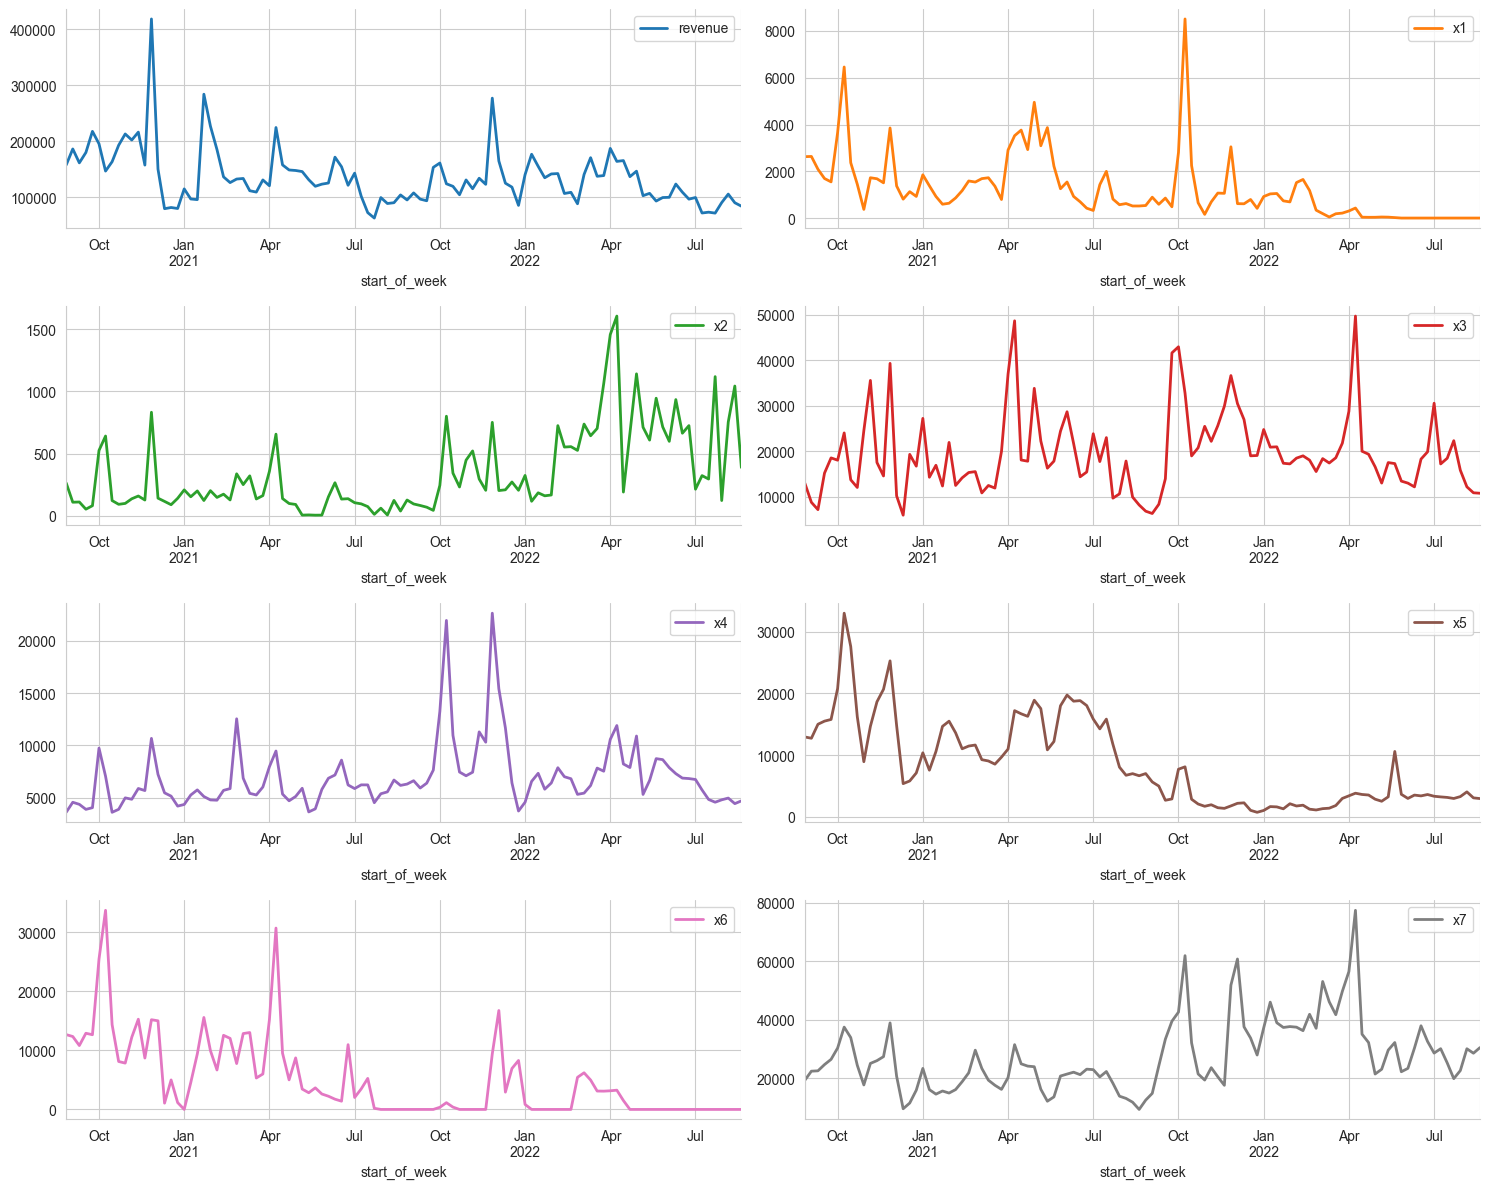

In [199]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

colors = [f"C{i}" for i in range(8)]

for ax,x,c in zip(axs.ravel(), ['revenue'] + [f"x{i}" for i in range(1,8)], colors):
    # filter df for ticker and plot on specified axes
    df.plot(x='start_of_week', y=x, color=c, lw=2, ax=ax)
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()

## Modelling

A mixed-media-model (MMM) is a regression model which takes into account carryover and shape effects of advertising.

Original model: Guadagni and Little (1983): response of sales to a media variable is assumed linear and immediate.

Corrections:
* <span style="color:cyan">Shape effects</span>: models the number of customers acquired as a function of marketing spend, or, the reach of the marketing spend, which might saturate and diminish at high levels of spend [Tellis (2006)]
* <span style="color:cyan">Carryover/Lag effect:</span> the portion of advertising effect that occurs in time periods following the pulse of advertising. Possible reasons: delayed consumer response, delayed purchase due to consumers’ inventory, or purchases from consumers who have heard from those who first saw the ad [Jin et al, Google Inc. (2017)]

Following [hints in the challenge](https://github.com/haensel-ams/recruitment_challenge/blob/master/DataScience_202209/README.md#some-hints), we will just model:
* carryover/lag effect (adstock) ✅
* trend/seasonality ✅
* shape effects due to saturation or diminishing returns ❌

### Media variables

#### 1. Carryover effect

To model the carryover effect of advertising, we transform the time series of media spend in one channel, $x_{t, m}$, through the adstock function:

$$x^*_{t,m} = \text{adstock}(x_{t-L+1, m},...,x_{t, m}; w_m, L) = \frac{\sum_{l=0}^{L+1}w_m(l)x_{t-l,m}}{\sum_{l=0}^{L+1}w_m(l)}$$

in order to obtain $x^*_{t,m}$, **the cumulative media effect as a weighted average of media spend in the current week and previous L − 1 weeks.** Here:

* $w_m$: nonnegative weight function  
* $L$: maximum duration of carryover effect assumed for a medium (without prior information, set to very large value)

There are a couple of ways the carryover effect can be modelled, depending on our choice of the weight function $w_m$.

##### 1.1. Geometric decay adstock
which assumes **advertising effect peaks at the same time period as ad exposure**:

$$w_m^g (l;\alpha_m)=\alpha_m^l, \quad l=0,...,L−1, \quad 0< \alpha_m <1$$
$\alpha_m$:  retention rate of ad effect of the $m$-th media from one period to the next.

##### 1.2. Delayed adstock
which assumes some media may take longer to build up ad effect and the peak effect may not happen immediately:

$$w_m^d (l;\alpha_m, \theta_m)=\alpha_m^{(l−\theta_m)^2}, \quad l=0,...,L−1, \quad  0< \alpha <1, \quad  0 \leq \theta_m \leq L−1$$

$\theta_m$: delay of the peak effect.

Figure 1 in [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf) shows the weight functions of geometric adstock and delayed adstock for the same value of $\alpha_m$.

#### 2. Shape effect

<span style="color:red">WRITE TEXT: kn=1, reach function</span>

### Non-media/Control variables

#### 1. Trend & Seasonal Components

We assume a sinusoidal seasonality, along with a linear trend. These would be part of the control variables we use during modelling.

In [200]:
# Fourier modes
fourier_modes = generate_fourier_modes(
    periods=df["dayofyear"] / 365.25,
    n_order=2
)

# trend feature

df["t"] = range(T)

df = pd.concat([df, fourier_modes], axis=1)

df.head()

,start_of_week,revenue,x1,x2,x3,x4,x5,x6,x7,dayofyear,t,sin_order_1,cos_order_1,sin_order_2,cos_order_2
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,243,0,-0.861693,-0.507430,0.874498,-0.485029
1,2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,250,1,-0.916409,-0.400244,0.733574,-0.679610
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,257,2,-0.957852,-0.287261,0.550307,-0.834962
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,264,3,-0.985424,-0.170118,0.335276,-0.942120
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,271,4,-0.998724,-0.050511,0.100892,-0.994897


#### 2. Other Control Variables

We add three events where there was a remarkable peak in revenue. We assume they are independent of seasonality (e.g. launch of a particular product).

In [201]:
# df[df.revenue > 250000].start_of_week

df["event_1"] = (df["start_of_week"] == "2020-11-29").astype(float)
df["event_2"] = (df["start_of_week"] == "2021-01-24").astype(float)
df["event_3"] = (df["start_of_week"] == "2021-11-28").astype(float)

### Model

Assuming:
* adstock transformation to model carryover effect
* shape effect expressed through Hill
* a sinusoidal seasonality + linear trend
* exceptional revenue days as control events
our final model is:

$$y_t = \tau + \sum_{m=1}^M \beta_m Hill(x^*_{t,m}) + \sum_{c=1}^C \gamma_c z_{t,c} + \epsilon_t(\sigma)$$

<span style="color:red">mention ordering of operations</span>

where:

* $y_t$: revenue in week $t$ (dependent variable)
* $\tau$: intercept/baseline revenue
* $\beta_m$: regression coefficient during shape-effect modelling [since we do not explicitly include shape-effects through a function like Hill, we restrict ourselves to the regression coefficient in Eq.(5) of [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)]
* $x^*_{t,m}$: adstock transformed variable corresponding to x_{t,m}$
* $\gamma_c$: effect of control variable $z_c$
* $\epsilon_t$: white noise is assumed to be uncorrelated with the other variables in the model and to have constant variance, $\sigma$

<span style="color:red">PRIORS</span>

In [202]:
from typing import Any, Dict, List, Optional

import pandas as pd
import pymc as pm

from pymc_marketing.mmm.base import MMM
from pymc_marketing.mmm.preprocessing import MaxAbsScaleChannels, MaxAbsScaleTarget
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.validating import ValidateControlColumns

class DelayedSaturatedMMM_mod(
    MMM, MaxAbsScaleTarget, MaxAbsScaleChannels, ValidateControlColumns
):
    def __init__(
        self,
        data: pd.DataFrame,
        target_column: str,
        date_column: str,
        channel_columns: List[str],
        validate_data: bool = True,
        control_columns: Optional[List[str]] = None,
        adstock_max_lag: int = 4,
        **kwargs,
    ) -> None:
        self.control_columns = control_columns
        self.adstock_max_lag = adstock_max_lag
        super().__init__(
            data=data,
            target_column=target_column,
            date_column=date_column,
            channel_columns=channel_columns,
            validate_data=validate_data,
            adstock_max_lag=adstock_max_lag,
        )

    def build_model(
        self,
        data: pd.DataFrame,
        adstock_max_lag: int = 4,
    ) -> None:
        date_data = data[self.date_column]
        target_data = data[self.target_column]
        channel_data = data[self.channel_columns]
        if self.control_columns is not None:
            control_data: Optional[pd.DataFrame] = data[self.control_columns]
        else:
            control_data = None
        coords: Dict[str, Any] = {
            "date": date_data,
            "channel": channel_data.columns,
        }

        if control_data is not None:
            coords["control"] = control_data.columns

        with pm.Model(coords=coords) as self.model:
            channel_data_ = pm.MutableData(
                name="channel_data",
                value=channel_data,
                dims=("date", "channel"),
            )

            target_ = pm.MutableData(name="target", value=target_data, dims="date")

            intercept = pm.Normal(name="intercept", mu=0, sigma=2)

            beta_channel = pm.HalfNormal(
                name="beta_channel", sigma=1, dims="channel"
            )  # ? Allow prior depend on channel costs?

            alpha = pm.Beta(name="alpha", alpha=1, beta=3, dims="channel")
            #alpha = pm.Uniform(name="alpha", lower=0, upper=1, dims="channel")

            lam = pm.Gamma(name="lam", alpha=3, beta=1, dims="channel")

            sigma = pm.HalfNormal(name="sigma", sigma=2)

            channel_adstock = pm.Deterministic(
                name="channel_adstock",
                var=geometric_adstock(
                    x=channel_data_,
                    alpha=alpha,
                    l_max=adstock_max_lag,
                    normalize=True,
                    axis=0,
                ),
                dims=("date", "channel"),
            )
            channel_adstock_saturated = pm.Deterministic(
                name="channel_adstock_saturated",
                var=logistic_saturation(x=channel_adstock, lam=lam),
                dims=("date", "channel"),
            )
            channel_contributions = pm.Deterministic(
                name="channel_contributions",
                var=channel_adstock_saturated * beta_channel,
                dims=("date", "channel"),
            )

            mu_var = intercept + channel_contributions.sum(axis=-1)

            if control_data is not None:
                control_data_ = pm.MutableData(
                    name="control_data", value=control_data, dims=("date", "control")
                )

                gamma_control = pm.Normal(
                    name="gamma_control", mu=0, sigma=2, dims="control"
                )

                control_contributions = pm.Deterministic(
                    name="control_contributions",
                    var=control_data_ * gamma_control,
                    dims=("date", "control"),
                )

                mu_var += control_contributions.sum(axis=-1)

            mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

            pm.Normal(
                name="likelihood",
                mu=mu,
                sigma=sigma,
                observed=target_,
                dims="date",
            )

<span style="color:red">alpha: uniform vs betaoperations</span>
<span style="color:red">reach function</span>

In [203]:
mmm = DelayedSaturatedMMM_mod(
    data=df,
    target_column="revenue",
    date_column="start_of_week",
    channel_columns=[f"x{i}" for i in range(1,8)],
    control_columns=[
        "event_1",
        "event_2",
        "event_3",
        "t",
        "sin_order_1",
        "cos_order_1",
        "sin_order_2",
        "cos_order_2",
    ],
    adstock_max_lag=13,
)

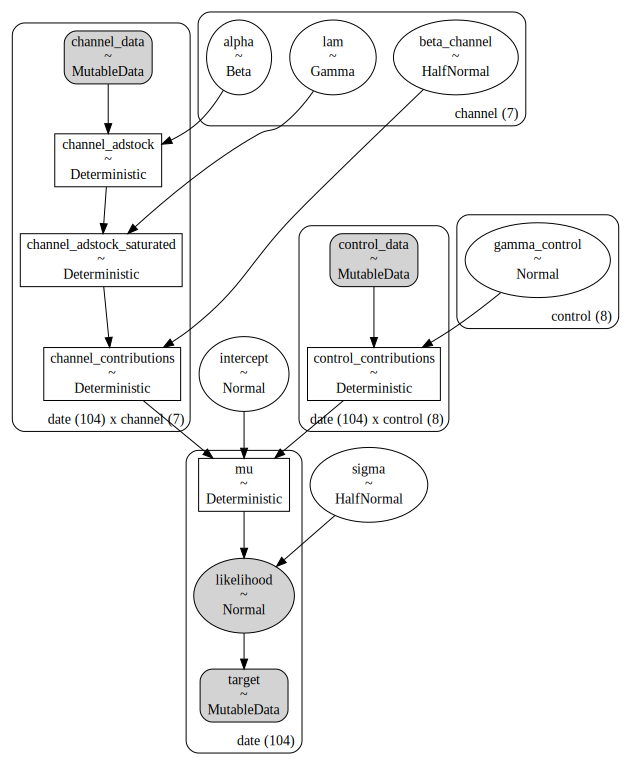

In [204]:
pm.model_to_graphviz(model=mmm.model)

In [205]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
mmm.fit(target_accept=0.98, chains=4, draws=1_000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


<span style="color:red">LIKELIHOOD</span>

In [206]:
mmm.fit_result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [207]:
az.summary(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.168,0.053,0.060,0.255,0.001,0.001,2263.0,2440.0,1.0
beta_channel[x1],0.035,0.064,0.000,0.108,0.001,0.001,2651.0,2366.0,1.0
beta_channel[x2],0.097,0.141,0.000,0.298,0.003,0.002,2296.0,1750.0,1.0
beta_channel[x3],0.146,0.152,0.000,0.365,0.003,0.002,2341.0,1832.0,1.0
beta_channel[x4],0.058,0.082,0.000,0.165,0.002,0.001,2998.0,2588.0,1.0
beta_channel[x5],0.125,0.119,0.000,0.303,0.002,0.002,2178.0,2083.0,1.0
beta_channel[x6],0.111,0.133,0.000,0.297,0.003,0.002,1923.0,1858.0,1.0
beta_channel[x7],0.232,0.176,0.001,0.517,0.004,0.003,1351.0,1068.0,1.0
alpha[x1],0.283,0.220,0.000,0.696,0.003,0.002,4794.0,2212.0,1.0
alpha[x2],0.305,0.223,0.000,0.713,0.003,0.002,4752.0,2425.0,1.0


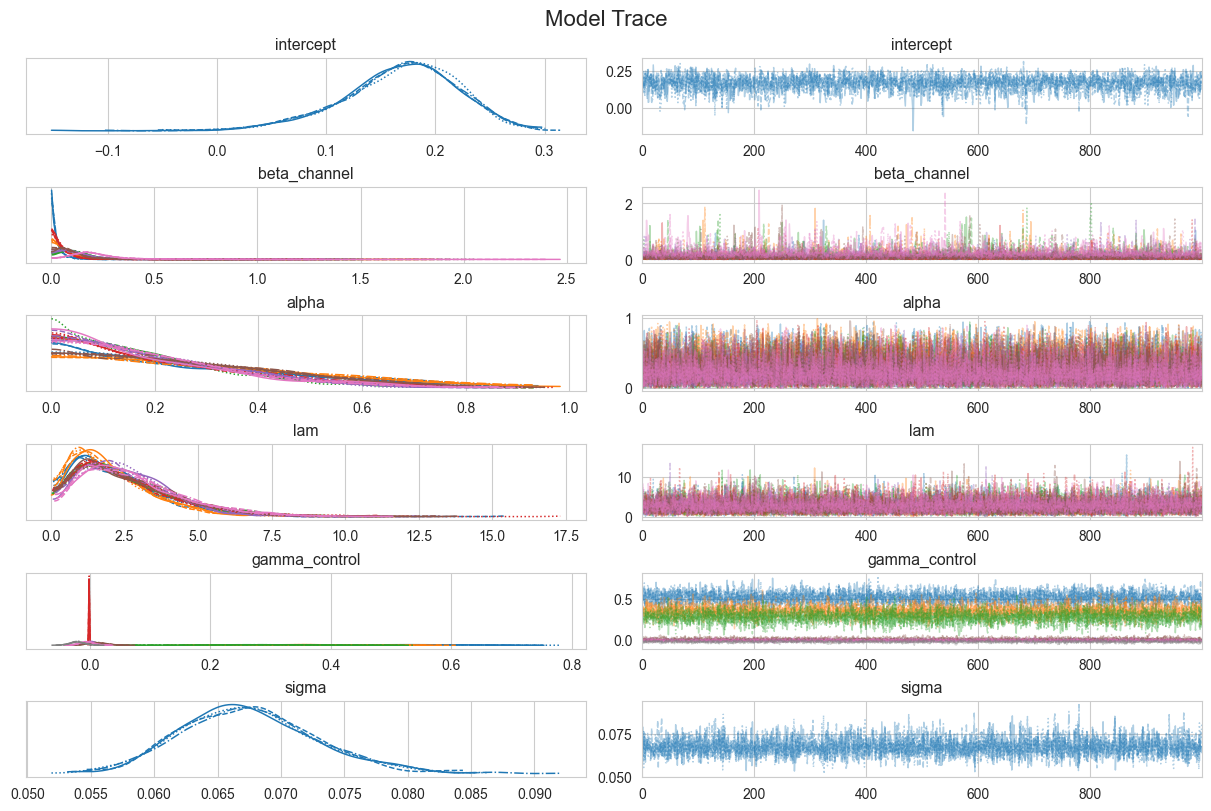

In [208]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"],
    compact=True,
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

Sampling: [alpha, beta_channel, gamma_control, intercept, lam, likelihood, sigma]


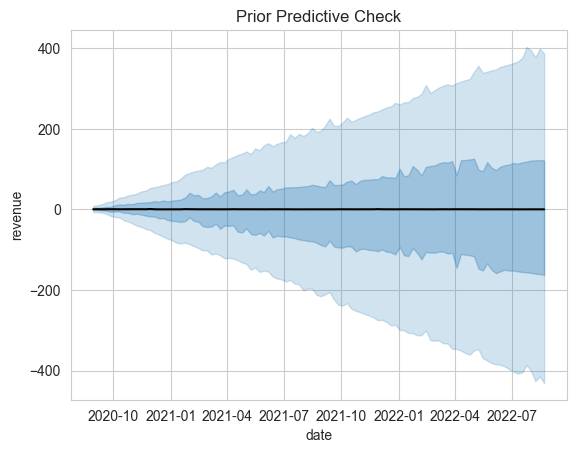

In [209]:
mmm.plot_prior_predictive();

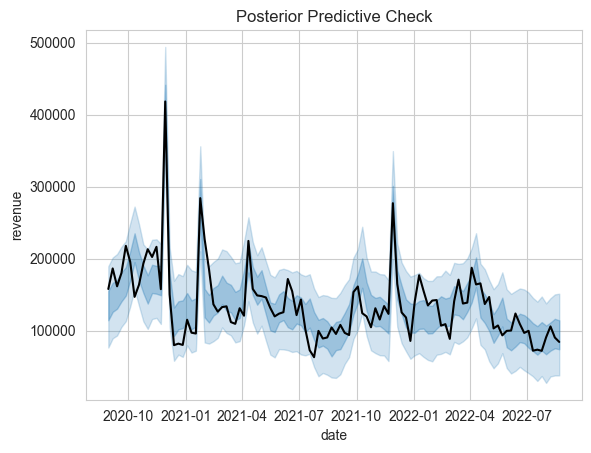

In [210]:
mmm.plot_posterior_predictive(original_scale=True);

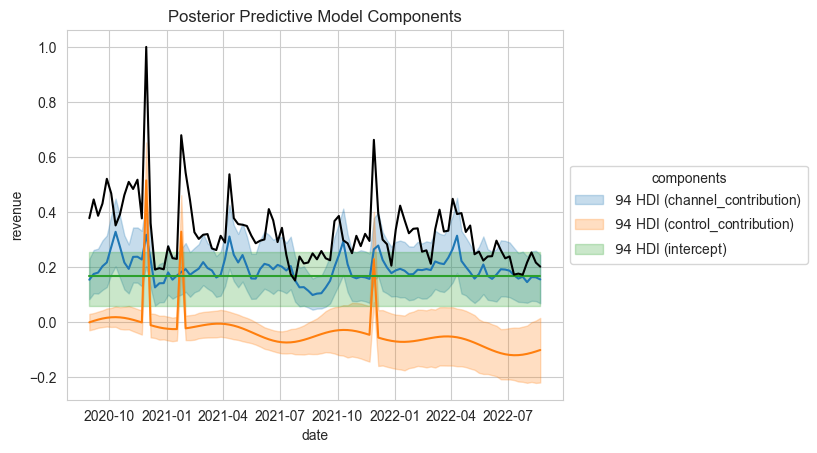

In [211]:
mmm.plot_components_contributions();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


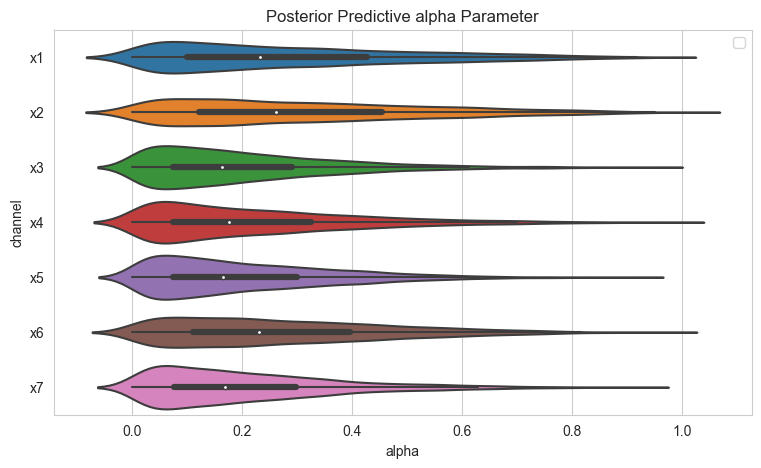

In [212]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
#ax.axvline(x=alpha, color="C0", linestyle="--", label=r"$\alpha$")
ax.legend(loc="upper right");

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


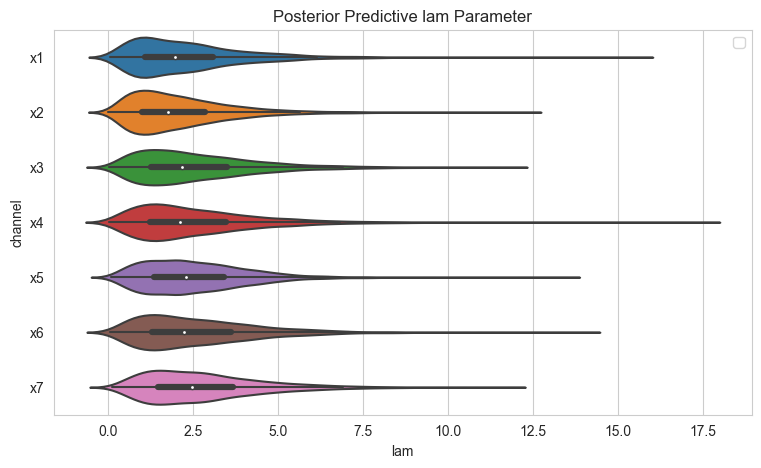

In [213]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
#ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
#ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


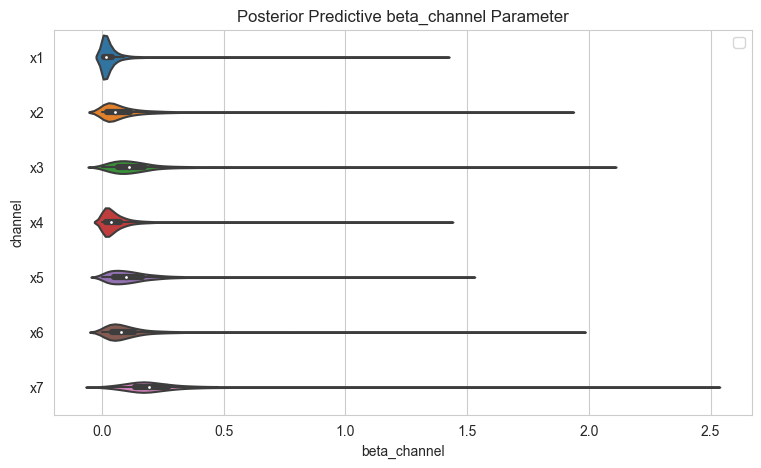

In [214]:
fig = mmm.plot_channel_parameter(param_name="beta_channel", figsize=(9, 5))
ax = fig.axes[0]
#ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
#ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


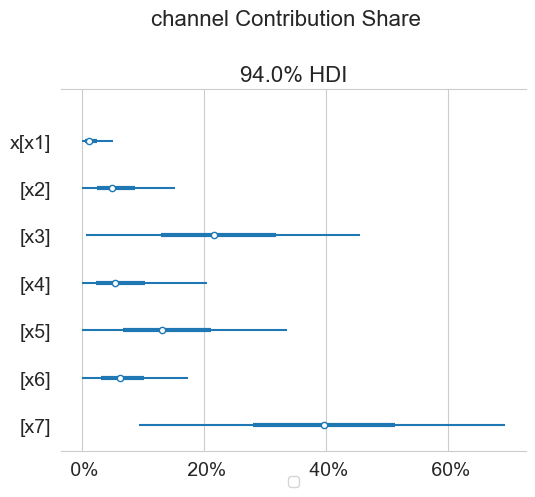

In [215]:
fig = mmm.plot_channel_contribution_share_hdi()
ax = fig.axes[0]
#ax.axvline(
#    x=contribution_share_x1,
#    color="C1",
#    linestyle="--",
#    label="true contribution share ($x_1$)",
#)
#ax.axvline(
#    x=contribution_share_x2,
#    color="C2",
#    linestyle="--",
#    label="true contribution share ($x_2$)",
#)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

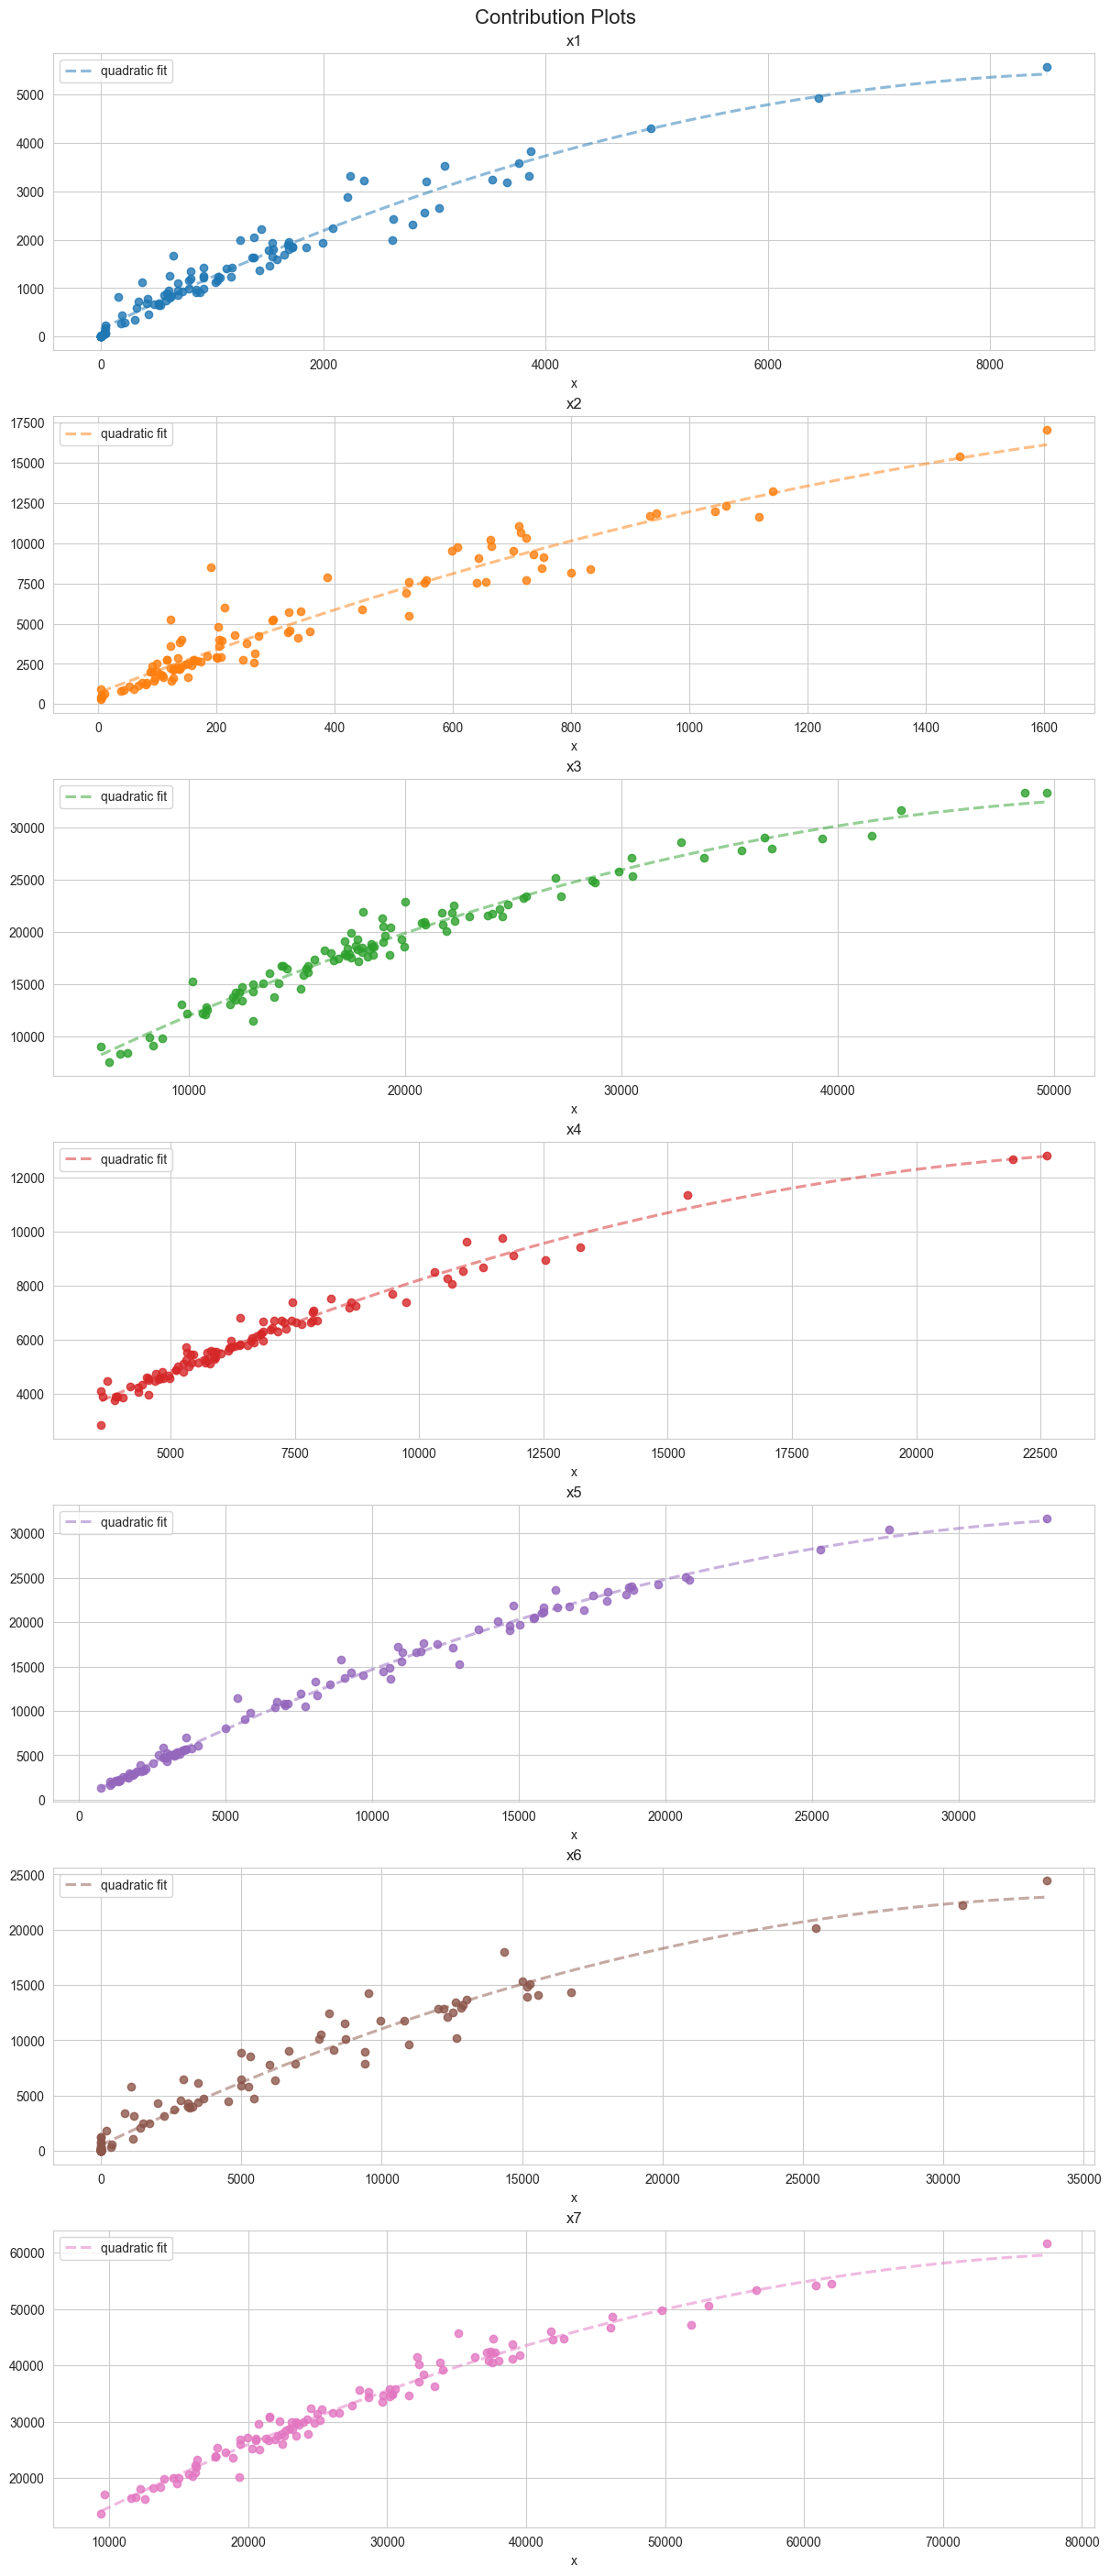

In [216]:
fig = mmm.plot_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

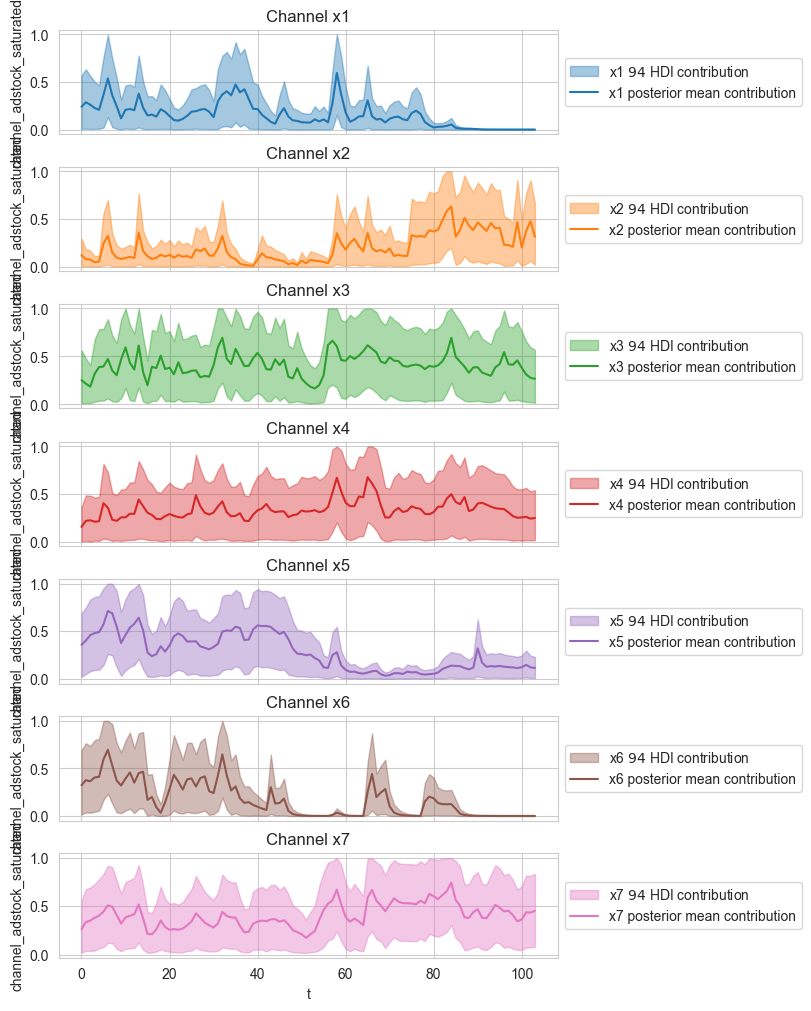

In [217]:
mean_estimated_channels_contribution = az.extract(
    data=mmm.fit_result,
    group="posterior",
    var_names=["channel_adstock_saturated"]
).mean("sample")

estimated_channels_contribution_hdi = az.hdi(ary=mmm.fit_result)["channel_adstock_saturated"]

fig, ax = plt.subplots(
    nrows=7, figsize=(8, 10), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x, in enumerate([f"x{i}" for i in range(1,8)]):
    ax[i].fill_between(
        x=df["t"],
        y1=estimated_channels_contribution_hdi.sel(channel=x)[:, 0],
        y2=estimated_channels_contribution_hdi.sel(channel=x)[:, 1],
        color=f"C{i}",
        label=f"{x} $94%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x=df["t"],
        y=mean_estimated_channels_contribution.sel(channel=x),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        ax=ax[i]
    )
    #sns.lineplot(
    #    x="t",
    #    y=f"{x}_adstock_saturated",
    #    data=df, color="black",
    #    label=f"{x} true contribution",
    #    ax=ax[i]
    #)
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


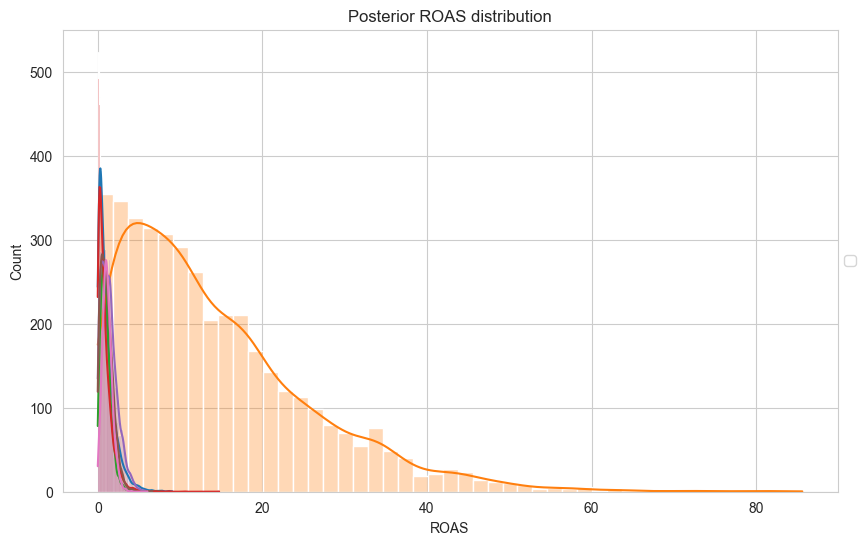

In [218]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / df[[f"x{i}" for i in range(1,8)]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
for x in [f"x{i}" for i in range(1,8)]:
    sns.histplot(roas_samples.sel(channel=x).to_numpy(), alpha=0.3, kde=True, ax=ax)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

# Challenges with Bayesian MMM’s
In one way, MMMs are conceptually simple. So how hard can it be to implement these kinds of models in a Bayesian framework? Well, not so fast! Things can get tricky when moving from concepts to implementation. Here is a list of possible stumbling points—which are precisely the kind of modeling decisions that our team at PyMC Labs can help with:

* Which likelihood function to choose? There are several feasible options here. Suppose we are modeling customer counts. We could consider discrete distributions like the Poisson distribution but also the Negative binomial distribution would be a potential option. Alternatively, if the number of customers is very large, we may also choose a Normal distribution; or perhaps a distribution with longer tails, such as the Cauchy or Student’s T distribution.

* What priors to use? Bayesian MMM’s will require priors over numerous parameters, such as regression coefficients on the control measures and the parameters in the reach and adstock functions. It is easy to end up with hundreds of parameters for state-of-the-art models. Some choices of priors may be less appropriate than others and lead to bad convergence problems. And how, exactly, should we use the data from lift tests to improve these priors?

* How should the reach and adstock functions be parameterized? The parametric forms of reach and adstock functions also have many options. Some ways of parameterizing these functions will be more interpretable than others and more readily provide insights to drive decision-making.

* How to select the correct model? In all likelihood, at least during development, dozens of different MMM variations may be considered. How can we rapidly assess which ones are most promising? It may be useful to have a system in place that allows rapid experimentation, allowing different background variables to be brought in and out of the MMM. Having a coherent and easy-to-change setup is very useful in supporting experimentation and evaluation of ‘what if’ questions.

* How can we ensure rigorous, correct, and fast inference? While Bayesian modeling is very powerful when working with real-world models for decision making it is crucial to ensure the inference is correct. There can be a number of problems that may trap a novice here, such as the correlation between MCMC chains, divergences in sampling, over-specified models… and even subtle aspects about interpreting the interplay between the model, the priors, and the data.